In [141]:
import pysftp
from datetime import date, timedelta, datetime
import pandas as pd
import seaborn as sns
import numpy as np
import requests

sns.set(rc={'figure.figsize':(11.7,8.27)})

def last_months(nb):
    cur_month = date.today().month
    cur_year = date.today().year
    for month in range(nb):
        month = cur_month - month
        year = cur_year
        while month < 1:
            month += 12
            year -= 1
        yield (year, month)
        
def resample_month(df, f=lambda x: x.mean()):
    out = f(df.groupby(lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=10))))
    out.index = out.index.tz_localize("CET") - pd.offsets.MonthBegin(1)
    #out = f(df.resample("M", origin="2001-01-01 00:00:00+01:00",label="left"))
    #out.index = out.index - pd.offsets.MonthBegin(1)
    return out

def resample_trimester(df, f=lambda x: x.mean()):
    out = f(df.groupby(lambda x: pd.to_datetime(datetime(year=x.year, month=((x.month-1)//3)*3+1, day=10))))
    out.index = out.index.tz_localize("CET") - pd.offsets.MonthBegin(1)
    return out

def trimester_duplicate_to_month(df):
    a = df
    b = df.copy()
    b.index = b.index + pd.offsets.MonthBegin(1)
    c = df.copy()
    c.index = c.index + pd.offsets.MonthBegin(2)
    
    return pd.concat([a,b,c]).sort_index()

Le marché des contrats de fourniture d'électricté est pour l'instant particulièrement complexe. Plus aucun fournisseurs ne propose de contrat fixe, ou alors à des prix prohibitifs. Les contrats variables sont très difficile à lire. Ils se basent sur des indices externes pour définir les prix, d'une manière à la fois précise et difficile à comprendre.

Dans ce document je détaille mes pérégrinations dans le monde merveilleux des fournisseurs. On tentera de répondre aux questions suivantes:

- Comment sont mis à jour les prix? 
- Sur quelle base? 
- Comment choisir un bon contrat?
- Quel est le meilleure contrat disponible?
- Et si j'étais ministre, qu'est-ce que je devrais faire pour améliorer la situation?

Ce guide a été écrit début novembre 2022, et contient des données datant de ce moment.

## Les bases

Un rappel des unités: l'énergie consommée est généralement notée en kWh (kilo-Watt-heure). Il s'agit de la consommation d'un appareil de 1000 Watts (=1kW) pendant une heure. Pensez par exemple à un aspirateur qui tourne pendant une heure. Une famille "moyenne", sans chauffage electrique, consomme dans les environs de 3500kWh par an. Je parlerai également régulièrement de MWh (Mega-Watt-heure), qui sont en fait simplement 1000 kWh. Les contrats d'électricité sont généralement facturés à l'échelle du kWh, et les prix sont en centimes d'euro par kWh, noté c€/kWh.

Notez que les contrats d'électricités proposent généralement un prix par mois ou par trimestre. Ces prix changent à la fin de chaque période. Les prix indiqués dans les contrats ne comprennent généralement que le prix de l'énergie elle-même (ce que vous devez au fournisseur), mais vous avez en plus les différents frais et taxes liés au transport et à la distribution de l'électricité, que vous devez à Elia (le transporteur haute-tension) ou à votre GRD (Ores/RESA/...) mais que votre fournisseur récupère pour eux.

On va donc ici se concentrer uniquement sur les prix de l'énergie et pas sur ces frais divers, qui sont **identiques** chez tout les fournisseurs, par définition.

Egalement, notez que votre fournisseur ne connait (presque) jamais votre consommation mensuelle d'électricité. Un ménage installé ne relève son compteur qu'un fois par an. L'exception étant les déménagements et les changements de fournisseurs.

Etant donné que votre fournisseur émet un prix différent chaque mois, il est nécessaire de "distribuer" votre consommation annuelle (la différence entre votre relevé de cette année et celui de l'année dernière) sur chaque mois. A cette fin, les fournisseurs d'énergie utilisent tous une courbe de consommation "typique" du ménage "moyen", basés sur les relévés du réseau. Ces courbes "**RLP**" (Real Load Profiles) sont distribuées par Synergrid. Voici la courbe des ménages qui sont chez Ores-Namur:

In [202]:
def myparse(years, months, days, hours, minutes):
    return [
        datetime(year, month, day, hour=hour, minute=minute)
        for year, month, day, hour, minute
        in zip(years, months, days, hours, minutes)
    ]

nb_dso_per_year = {
    2021: 20,
    2022: 25
}

rlp_data = {
    year:
    pd.read_excel('contrats_elec/rlp.xlsx',
                   sheet_name=str(year),
                   skiprows=[1,2,3,4],
                   header=[1],
                   usecols=[1,2,3,4,5] + list(range(7,nb_dso_per_year[year]+7)),
                   parse_dates=[[0,1,2,3,4]], date_parser=myparse
                  ).rename(columns={"Year_Month_Day_h_Min": "date"})
    for year in nb_dso_per_year
}

for year in rlp_data:
    rlp_data[year] = pd.melt(rlp_data[year],id_vars=["date"],var_name="GRD")
    rlp_data[year]["date"] = rlp_data[year]["date"].dt.tz_localize('CET', ambiguous="infer")

rlp_elec_quarterhour = pd.concat([df.groupby("date").mean() for df in rlp_data.values()]).sort_index()
rlp_elec_hour = rlp_elec_quarterhour.resample("H", origin="2001-01-01 00:00:00+01:00", label="left").sum()
rlp_elec_daily = rlp_elec_quarterhour.resample("D", origin="2001-01-01 00:00:00+01:00", label="left").sum()
rlp_elec_monthly = resample_month(rlp_elec_hour, lambda x: x.sum())

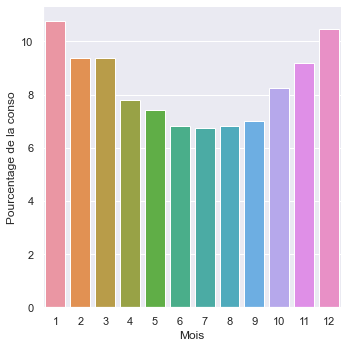

In [175]:
df = (rlp_elec_daily.loc["2022"].groupby(pd.Grouper(freq='M')).sum()*100).reset_index()
df["month"] = df.date.dt.month
g = sns.catplot(data=df, x="month", y="value", kind="bar")
g.set(xlabel='Mois', ylabel='Pourcentage de la conso')
None

On consomme moins d'électricité en été, plus en hiver. Il faut y voir l'impact

- du chauffage électrique (même si vous n'en avez pas, on parle ici du belge "moyen")
- de la nécessité d'allumer plus la lumière
- de la plus grande présence chez soit
- (entre autres choses)

Même si vous consommez différement, vous payerez votre énergie comme si vous aviez suivi **exactement** cette répartition. Que vous ayez du chauffage électrique ou pas, que vous ayez passé 3 mois dans un pays chaud en plein hiver, peu importe. Vous êtes facturé sur cette base. C'est valable aussi si vous avez un compteur intelligent, du moins en Wallonie: les fournisseurs n'en tiennent pas encore compte.

Les seuls moyens d'obliger un fournisseur à vous faire payer exactement ce que vous avez consommé est de changer de contrat chaque mois (car cela entraîne un relevé de compteur). Malheureusement, cela n'est pas une bonne idée, comme on va le voir plus loin.

## Comment lire un contrat d'électricité

Les fournisseurs ont tous signés un charte avec le régulateur du marché (la CREG) et se sont engagés à fournir des "cartes tarifaires" plus ou moins standardisées et lisible. Ce n'est en fait pas vraiment le cas.

Voici un screenshot de la carte tarifaire du contrat Flow de Engie, pour la Wallonie:

![Un exemple de contrat](contrats_elec/engie_flow.png)

L'oeil est immédiatement attiré par la section "prix indexés de l'énergie". On vous donne des prix trimestriels (qui seront dons mis à jour chaque trimestre), et une estimation de prix annuel.

Pourtant, ces prix sont une illusion. Pour beaucoup de contrats, ils ne contiennent simplement pas le prix que vous allez payer ce mois/trimestre/année. Si je surligne les parties effectivement utiles du contrat, on obtient ceci:

![La partie réellement importante en jaune](contrats_elec/engie_flow_important.png)

Oui, c'est majoritairement dans les petits caractères. Voici une copie du texte:

- Redevance fixe: 53€/an
- Le prix de l’électricité est indexé mensuellement. 
- Le paramètre d’indexation est la moyenne arithmétique des cotations journalières Day Ahead EPEX SPOT Belgium (ci-après EPEX DAM) durant le mois de fourniture. 
- La valeur du EPEX DAM du mois en cours ne sera connue qu'en fin de mois \[les prix sont donc informatifs\]
- Les formules de calcul des prix sont les suivantes:
  - Normal = 0,9800 + 0,1067 x EPEX DAM
  - Tarif bihoraire heures pleines = 0,7900 + 0,1177 x EPEX DAM
  - Tarif bihoraire heures creuses = 0,5900 + 0,0978 x EPEX DAM
  - Exclusif nuit = 0,5900 + 0,0978 x EPEX DAM

Passons ligne par ligne sur le contenu du texte.

Tout d'abord, on vous signale que la redevance fixe est de **53€/an**. Cette redevance est généralement dûe en intégralité pour toute année de contrat commencée, donc il s'agit d'un moyen d'empècher les consommateurs de changer trop souvent de fournisseur. Prenez en compte cette redevance quand vous changez "avant la fin de l'année" de fournisseur.

Ensuite on vous explique que les prix du contrat changent chaque mois, en suivant le \**grande inspiration*\* "Day Ahead EPEX SPOT Belgium". Sous ce nom se cache en fait le marché "achat au jour le jour" de gros de l'électricité, aussi appelé le Belpex. Il s'agit d'un des (nombreux) marchés sur lequel les fournisseurs peuvent acheter leur énergie avant de vous la revendre (on rapelle que la majorité des fournisseurs ne produisent pas l'énergie qu'ils vendent).

Il est indiqué dans le contrat que le prix *du mois M* (disons, Janvier) est calculé *à la fin de ce mois M* (donc le 31 Janvier) sur base de la moyenne des prix journaliers du Belpex durant ce mois M (toujours Janvier). Par exemple, si le prix sur le belpex a été de 100€/MWh dans les deux premières semaines de Janvier, puis à 150€/MWh les deux suivantes, l'indice "EXPEX DAM" utilisé dans le contrat vaudra 125€/MWh. On ne connait donc pas le prix de l'énergie au moment où on la consomme!

Ce système, basé sur des marchés "day-ahead" (achat le jour d'avant pour le jour d'après) est à mettre en parallele avec les contrats basés sur les marchés "futures", où on va regarder, par exemple, durant le mois M à quel prix le marché nous vend l'énergie du mois M+1, et facturer le mois M+1 aux consommateurs finaux à ce prix là. Dans ce système, le prix du mois courant est connue à l'avance.

Il existe une **véritable jungle** d'indices différents. Certains sont calculés par mois, d'autre par trimestres. Certains sur du day-ahead, d'autres sur du future. D'autres encore sur différentes périodes. J'y reviens plus loin dans ce document. Concentrons nous en attendant sur le véritable coeur de la fiche tarifaire: les formules de calcul.

Pour rappel, il existe 4 "méthode de facturation de l'énergie", en fonction de votre type de compteur. Les ménages disposant de compteurs "normaux" paient un tarif unique (nommé au dessus "normal"). Les compteurs bihoraires disposent de deux tarifs, le tarif d'heure pleine (en journée en semaine) et celui d'heure creuse (généralement entre 22h et 7h ainsi que le week-end). Il existe aussi des compteurs "exclusifs nuit", utilisés généralement pour le chauffage électrique. Chaque contrat propose donc quatre formule de calcul. Je me concentre dans la suite de ce document sur le tarif "normal".

Les tarifs sont partout calculés comme suit: "$x * \text{indice} + y$". $x$ est appelé le multiplicateur et $y$ le biais. Dans notre contrat Flow ci-dessus, on nous donne "Normal = 0,9800 + 0,1067 x EPEX DAM", donc:
$$x=0.1067, y=0.98, \text{indice} = \text{EPEX DAM}$$


Le biais $y$ est une valeur en c€/kWh que le fournisseur prend peu importe la valeur de l'indice utilisé. Ensuite le fourni prend une certaine marge proportionnelle à la valeur de l'indice via $x$. 

EPEX DAM étant donné en €/MWh, il y a dans la valeur de $x$ une conversion implicite vers du c€/kWh. En gros vous pouvez simplement retenir qu'en multipliant par 100 la valeur de $x$ on obtient le pourcentage de l'indice utilisé dans le prix final. Ici cela donne $106.7\%$, donc Engie prend $6.7\%$ de marge sur la valeur du Belpex.

J'espère que vous suivez toujours! Ces indices, multiplicateurs et biais sont en dur dans votre contrat; votre fournisseur ne peut pas en changer après la signature.

**La "bonne" manière de comparer les contrats n'est donc pas de regarder leur prix à un moment T, mais de comparer les frais fixes, les indices utilisés, les biais et multiplicateurs.**

## Les différents contrats disponibles
J'ai ici listés les différents contrats disponibles en Novembre 2022 en Wallonie. Les prix sont souvent identiques à Bxl, mais je n'ai pas vérifié. Notez que les tarifs changent chaque mois, y compris les multiplicateurs, biais, et indices. Le meilleur contrat à un mois donné peut devenir beaucoup moins bon le mois suivant!

:::{.callout-note}
Je me dois de signaler que j'ai demandé à la CREG (le régulateur fédéral) de me fournir une liste des contrats existant et historique pour écrire ce poste de blog. Ils ont (de leur aveu) une telle base de donnée, mais ont refusés de me la faire parvenir au motif que ma demande était "abusive".

Il est désespérant que j'aie à refaire le travail d'un organisme public et que par ailleurs il refuse de partager une information qui devrait être publique, ne serait-ce que par bon sens, mais également légalement, via la loi sur la publicité de l'administration.
:::

In [73]:
from collections import namedtuple
Contract = namedtuple('Contract', ['company', 'name', "annual", 'index', 'mono', 'day', 'night', "excl_night"])

contracts = [
    #https://www.luminus.be/-/media/general/pricelists/fr/ecf0c_fr_comfyflex_elec.pdf?la=fr&hash=5F11B5B22BBBDCE41C91439C16642213E329A510
    Contract("Luminus", "ComfyFlex", 63.60, "belpex_q",
             (0.1128, 4.4410),
             (0.1350, 4.3480),
             (0.0940, 4.0000),
             (0.0940, 4.0000)),
    #https://www.luminus.be/-/media/general/pricelists/fr/ecf0cfrcomfyflexpluselec.pdf?la=fr&hash=D9582D0EE11ECEDB736E1A94C6A68834D60E2E7E
    Contract("Luminus", "ComfyFlex+", 63.60, "belpex_q",
             (0.1128, 6.4410),
             (0.1350, 6.3480),
             (0.0940, 6.0000),
             (0.0940, 6.0000)),
    Contract("Luminus", "Actif+", 79.50, "EMarketCWE",
             (0.1160, 22.6743),
             (0.1364, 24.8863),
             (0.0961, 20.2263),
             (0.0961, 20.2263)),
    #https://www.luminus.be/-/media/general/pricelists/fr/ebac_fr_basic_elec.pdf?la=fr&hash=FAA5FBE4C127D5CE547A95B68265DA833B2A3579
    Contract("Luminus", "Basic", 21.20, "belpex_q",
             (0.1128, 0.9700),
             (0.1350, 1.5200),
             (0.0940, 1.2700),
             (0.0940, 1.2700)),
    Contract("Luminus", "Eco+", 79.50, "EMarketCWE",
             (0.1150, 22.6743),
             (0.1304, 24.8863),
             (0.1022, 20.2263),
             (0.1022, 20.2263)),
    Contract("Luminus", "Ecoflex", 68.90, "EMarketCWE",
             (0.1150, 22.6868),
             (0.1304, 24.7151),
             (0.1022, 20.4856),
             (0.1022, 20.4856)),
    Contract("Luminus", "Essential", 42.40, "EMarketCWE",
             (0.1160, 22.5343),
             (0.1364, 22.6219),
             (0.0961, 22.2207),
             (0.0961, 22.2207)),
    #https://www.luminus.be/-/media/general/pricelists/fr/eoc_fr_optimal_elec.pdf?la=fr&hash=66A1B6337938886C231B22B16D60417BD9F384AC
    Contract("Luminus", "Optimal", 53.00, "EMarketCWE",
             (0.1160, 23.2643),
             (0.1364, 25.4019),
             (0.0961, 20.9507),
             (0.0961, 20.9507)),
    #https://totalenergies.be/static/marketing-documents/b2c/tariff-card/latest/PIXEL_ELECTRICITY_WAL_FR.pdf
    Contract("TotalEnergies", "Pixel", 25, "belpex_m_rlp",
             (0.1063, 3.150),
             (0.1250, 3.150),
             (0.0930, 3.150),
             (0.0950, 3.000)),
    #https://totalenergies.be/static/marketing-documents/b2c/tariff-card/latest/PIXEL-BLUE_ELECTRICITY_WAL_FR.pdf
    Contract("TotalEnergies", "Pixel Blue", 70, "belpex_m_rlp",
             (0.1063, 3.200),
             (0.1250, 3.200),
             (0.0930, 3.200),
             (0.0950, 3.050)),
    #https://cdn.eneco.be/downloads/fr/general/tk/BC_032_012210_FR_ENECO_POWER_VARIABLE.pdf
    Contract("Eneco", "Soleil & Vent Variable", 65, "endex103",
             (0.1, 6.810),
             (0.1, 14.740),
             (0.1, 0.416),
             (0.1, 0.416)),
    #https://cdn.eneco.be/downloads/fr/general/tk/BC_032_012210_FR_ENECO_POWER_FLEX.pdf
    Contract("Eneco", "Soleil & Vent Flex", 65, "belpex_q_rlp",
             (0.1,  5.571),
             (0.1,  5.711),
             (0.1,  5.458),
             (0.1,  5.458)),
    #https://www.engie.be/api/engie/be/ms_1/pricing/v1/public/pricesAndConditionsPDF?document=E_EASY_R_GREY_C_I_12_W_F&monthOffset=0&segment=R&language=F
    Contract("Engie", "Easy", 58.30, "endex103",
             (0.1091,  4.4950),
             (0.1336,  4.5140),
             (0.0898,  3.7180),
             (0.0898,  3.7180)),
    #https://www.engie.be/api/engie/be/ms_1/pricing/v1/public/pricesAndConditionsPDF?document=E_FLOW_R_GREY_C_I_00_W_F&monthOffset=0&segment=R&language=F
    Contract("Engie", "Flow", 53.00, "belpex_m",
             (0.1067,  0.98),
             (0.1177,  0.79),
             (0.0978,  0.59),
             (0.0978,  0.59)),
    #https://www.engie.be/api/engie/be/ms_1/pricing/v1/public/pricesAndConditionsPDF?document=E_DIRECT_R_GREY_C_I_12_W_F&monthOffset=0&segment=R&language=F
    Contract("Engie", "Direct", 26.34, "belpex_m",
             (0.1081,  2.836),
             (0.1303,  2.9160),
             (0.0883,  2.7070),
             (0.0883,  2.7070)),
    #https://profile.dats24.be/api/v1/ratecard?energyType=electricity&&contractType=variable&language=fr
    Contract("DATS24", "Variable", 35.04, "belpex_m_rlp",
             (0.1067,  0.592),
             (0.1269,  0.592),
             (0.0967,  0.592),
             (0.0967,  0.592)),
    #https://files.octaplus.be/tariffs/E_OCTA_ECOCHILL_RE_WL_FR.pdf
    Contract("OCTA+", "Eco Chill", 130.00,  "belpex_m_rlp",
             (0.1127,  1.25),
             (0.1284,  1.25),
             (0.0971,  1.25),
             (0.1027,  1.25)),
    #https://files.octaplus.be/tariffs/E_OCTA_CHILL_RE_WL_FR.pdf
    Contract("OCTA+", "Chill", 65.00, "belpex_m_rlp",
             (0.1127, 1),
             (0.1284, 1),
             (0.0971, 1),
             (0.1027, 1)),
    # attention reduction non comptee chez MEGA
    Contract("MEGA", "Smart", 42.40, "belpex_m",
             (0.1195,  2.55),
             (0.1425,  2.55),
             (0.1065,  2.55),
             (0.1065,  2.55)),
    #https://my.mega.be/resources/tarif/Mega-FR-EL-B2C-WL-092022-Online.pdf
    # attention reduction non comptee chez MEGA
    Contract("MEGA", "Online", 15.9, "belpex_m",
             (0.115,  1.2),
             (0.115,  1.2),
             (0.115,  1.2),
             (0.115,  1.2)),
    #https://my.mega.be/resources/tarif/Mega-FR-EL-B2C-WL-092022-Cosy.pdf
    # attention reduction non comptee chez MEGA
    Contract("MEGA", "Cosy", 58.3, "belpex_m",
             (0.1195,  2.55),
             (0.1425,  2.55),
             (0.1065,  2.55),
             (0.1065,  2.55)),
    # attention reduction non comptee chez MEGA
    Contract("MEGA", "Group", 68.9, "belpex_m",
             (0.115,  2.55),
             (0.115,  2.55),
             (0.115,  2.55),
             (0.115,  2.55)),
]

In [75]:
from IPython.display import display, Markdown, Latex, HTML

In [119]:
table_out = """
<style type="text/css">
    .contracts_table tr td {
        padding: 3px 10px;
    }
    .contracts_table th {
        text-align: center;
    }
    
    .contracts_table .mono {
        background-color: rgba(255, 0, 0, 0.3);
        
    }
    
    .contracts_table .day {
        background-color: rgba(255, 255, 0, 0.3);
    }
    
    .contracts_table .night {
        background-color: rgba(0, 0, 0, 0.3);
    }
    
    .contracts_table .excl_night {
        background-color: rgba(0, 0, 100, 0.3);
    }
    
    .contracts_table .val {
        text-align: right;
    }
    
    .contracts_table tr:nth-child(even) {
        background-color: #dedede;
    }
    
    .contracts_table tr:nth-child(even):hover {
        background-color: #bbdede;
    }
    
    .contracts_table tr:nth-child(odd):hover {
        background-color: #aacdcd;
    }
</style>
<table class='contracts_table'>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th rowspan="2">Indice</th>
        <th colspan="2" class="mono">Monohoraire<br>☀️/🌙</th>
        <th colspan="2" class="day">Bihoraire ☀️</th>
        <th colspan="2" class="night">Bihoraire 🌙</th>
        <th colspan="2" class="excl_night">Exclusif nuit 🌡️</th>
    </tr>
    <tr>
        <th class="mono">x</th>
        <th class="mono">y</th>
        <th class="day">x</th>
        <th class="day">y</th>
        <th class="night">x</th>
        <th class="night">y</th>
        <th class="excl_night">x</th>
        <th class="excl_night">y</th>
    </tr>
"""

for contract in contracts:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td>{contract.index}</td>
        <td class="mono val">{contract.mono[0]:0.4f}</td>
        <td class="mono val">{contract.mono[1]:0.3f}</td>
        <td class="day val">{contract.day[0]:0.4f}</td>
        <td class="day val">{contract.day[1]:0.3f}</td>
        <td class="night val">{contract.night[0]:0.4f}</td>
        <td class="night val">{contract.night[1]:0.3f}</td>
        <td class="excl_night val">{contract.excl_night[0]:0.4f}</td>
        <td class="excl_night val">{contract.excl_night[1]:0.3f}</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

On voit qu'il y a une pléthore d'offre différentes. Et encore, le nombre de contrat différent a été considérablement réduit depuis le début de la crise énergétique.

Pour un client possédant un compteur monohoraire, la comparaison se révèle compliquée: il y a plusieurs indices différents. Pour le client en bihoraire, la tâche est encore plus hardue: il y a deux fois plus de paramètres à considérer!

On peut tenter de simplifier quelque peu cette grille pour le bihoraire, en regardant la répartition "moyenne" de consommation en heure pleine et en heure creuse, via les courbes RLP dont on a discuté plus haut. Cela donne en gros que c'est 50/50. Le ménage "moyen" consomme autant en heure creuse qu'en heure pleine. Faisons cette hypothèse à partir de maintenant. On va aussi abandonner l'analyse de l'exclusif nuit, qui concerne une minorité.

In [126]:
table_out = """
<table class='contracts_table'>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th rowspan="2">Indice</th>
        <th colspan="2" class="mono">Monohoraire</th>
        <th colspan="2" class="day">Bihoraire (moyenne)</th>
    </tr>
    <tr>
        <th class="mono">x</th>
        <th class="mono">y</th>
        <th class="day">x</th>
        <th class="day">y</th>
    </tr>
"""

for contract in contracts:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td>{contract.index}</td>
        <td class="mono val">{contract.mono[0]:0.4f}</td>
        <td class="mono val">{contract.mono[1]:0.3f}</td>
        <td class="day val">{(contract.day[0]+contract.night[0])/2:0.4f}</td>
        <td class="day val">{(contract.day[1]+contract.night[1])/2:0.3f}</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

## Les différents indices

Je décris ici les différents indices. Le but est à la fin de pouvoir les comparer efficacement.

### Le marché day-ahead: `belpex_m`, `belpex_q`, `belpex_m_rlp`, `belpex_q_rlp`

Le marché day-ahead, est, comme je l'expliquais plus haut, le marché où un fournisseur peut acheter au jour J l'électricité qu'il doit fournir au jour J+1. Ce marché est régulé et supervisé par des règles européennes, notamment de transparence. Son historique est librement accessible.

Il en existe un par pays. Pour la Belgique, il s'agit du Belpex, aussi appelé EPEX DAM, EPEX SPOT, BELPEX SPOT, et d'autres variantes. Au cours de chaque journée, les différents opérateurs sur le marché s'échange l'énergie heure par heure pour le lendemain.  On obtient donc, chaque jour, 24 prix, un pour chaque heure de la journée. Le prix de la journée est la moyenne de ces prix.

Voici la forme qu'à pris le Belpex ces derniers mois:


In [327]:
nb_months = 12*6+4
cnopts = pysftp.CnOpts()
cnopts.hostkeys = None

#connection = pysftp.Connection(
#    host="sftp-transparency.entsoe.eu",
#    username="guillaumederval@gmail.com",
#    password="LOUL",
#    port=22,
#    cnopts=cnopts
#)



#for (year, month) in last_months(2):
#    connection.get(f"/TP_export/DayAheadPrices_12.1.D/{year}_{month:02d}_DayAheadPrices_12.1.D.csv", f"contrats_elec/elec_day_ahead_price/{year}-{month:02d}.csv")
    
#connection.close()

all_data = []
for (year, month) in last_months(nb_months):
    data = pd.read_csv(f"contrats_elec/elec_day_ahead_price/{year}-{month:02d}.csv", sep="\t", parse_dates=["DateTime", "UpdateTime"])
    data = data[data.AreaName == "BE BZN"][["DateTime", "Price"]].copy().set_index("DateTime")
    all_data.append(data)
    
belpex_hourly = pd.concat(all_data).sort_index().rename(columns={"Price": "price"})
belpex_hourly.index = belpex_hourly.index.tz_localize('UTC').tz_convert('CET')

# remove the first index as it is incomplete. Keep the last one (incomplete but useful)
belpex_daily_avg = belpex_hourly.resample("D", origin="2001-01-01 00:00:00+01:00",label="left").mean()
belpex_month_avg = resample_month(belpex_hourly).iloc[1: , :]
belpex_trimester_avg = resample_trimester(belpex_hourly).iloc[1: , :]
belpex_m = belpex_month_avg
belpex_q = trimester_duplicate_to_month(belpex_trimester_avg)

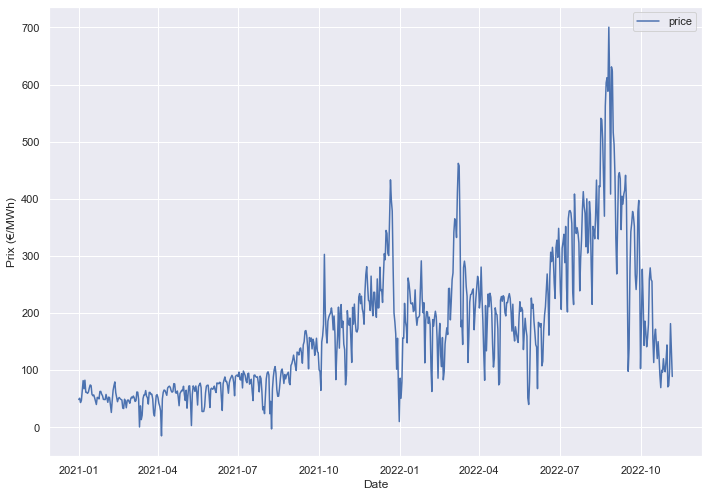

In [136]:
g = sns.lineplot(data=belpex_daily_avg.loc["2021":"2022"])
g.set(xlabel='Date', ylabel='Prix (€/MWh)')
None

Vu que le prix n'est connu qu'au jour-le-jour, le tarif auquel vous payez votre énergie dans un contrat basé sur Belpex n'est pas connu au moment où vous consommez votre électricité: elle ne l'est qu'en fin de mois ou de trimestre, après coup.

A partir de là, on définit différents indices:

#### `belpex_m`, moyenne mensuelle
`belpex_m` est la moyenne des cotations (journalières ou horaire, c'est la même chose) du Belpex pour un mois donné. Le prix du mois de Novembre 2022 sera donc la moyenne des cotations entre le 1ier Novembre 2022 et le 30 Novembre 2022.

Voici le graphique de la valeur du `belpex_m`. La valeur pour novembre est la moyenne du mois arrétée à la date de dernière mise à jour de cet article.

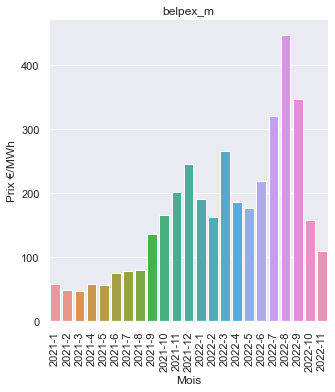

In [185]:
df = belpex_m.loc["2021":"2022"].reset_index()
df["month"] = df.DateTime.dt.year.astype(str) + "-" + df.DateTime.dt.month.astype(str)
g = sns.catplot(data=df, x="month", y="price", kind="bar")
g.set(xlabel='Mois', ylabel='Prix €/MWh')
g.set_xticklabels(rotation=90)
g.set(title="belpex_m")
None

#### `belpex_q`, moyenne trimestrielle
`belpex_q` (`q` pour 'quarter' ou trimestre en anglais) est la moyenne des cotations (journalières ou horaire, c'est la même chose) du Belpex pour un trimestre donné. Le prix du mois de Novembre 2022 sera donc la moyenne des cotations entre le 1ier Octobre 2022 et le 31 Decembre 2022, le trimestre dans lequel se trouve le mois de Novembre.

On a la propriété que pour un certain trimestre Q (disons, le 4ième) contenant les mois M, M+1 et M+2 (Octobre, Novembre, Décembre par exemple), le prix du `belpex_q` pour le trimestre Q est la moyenne du `belpex_m` pour les trois mois du trimestre. Autrement dit, le prix du dernier trimestre est égal à la moyenne des prix des mois du trimestre. Mais vous ne consommez pas de manière égale chaque mois...

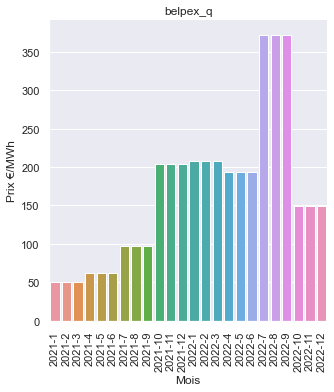

In [184]:
df = belpex_q.loc["2021":"2022"].reset_index()
df["month"] = df.DateTime.dt.year.astype(str) + "-" + df.DateTime.dt.month.astype(str)
g = sns.catplot(data=df, x="month", y="price", kind="bar")
g.set(xlabel='Mois', ylabel='Prix €/MWh')
g.set_xticklabels(rotation=90)
g.set(title="belpex_q")
None

#### `belpex_m_rlp` et `belpex_q_rlp`, moyennes pondérées
Une variante très utilisée des indices ci-dessus est leur version pondérée par la courbe RLP (souvenez-vous, c'est la courbe de la consommation moyenne des ménages). L'idée est que si un ménage moyen consomme plus un certain jour plutôt qu'un autre, ce premier jour devrait compter "plus" dans la moyenne que l'autre.

Cela permet au fournisseur de coller plus à ses coûts effectifs (les jours où les ménages consomment "plus", il doit effectivement acheter "plus" d'électricité), et cela à un effet mathématique intéressant: on a la propriété que si un ménage consomme comme le ménage moyen (en suivi la courbe RLP), alors le prix facturé à un ménage ayant un tarif basé sur `belpex_m_rlp` (mensuel) sera identique que s'il était sur `belpex_q_rlp` (trimestriel).

Les indices pondérés par RLP sont toujours un peu plus cher, en moyenne de 2%, car on consomme plus au moment où les prix sont plus chers (en fait c'est l'inverse: les prix sont plus chers car on consomme plus ;-))

In [176]:
df = pd.concat([belpex_hourly, rlp_elec_hour], axis=1, join="inner")
df["rp"] = df.price * df.value

belpex_m_rlp = resample_month(df, lambda x: x.sum())
belpex_m_rlp["price"] = belpex_m_rlp["rp"] / belpex_m_rlp["value"]
belpex_m_rlp = belpex_m_rlp[["price"]]

belpex_q_rlp = resample_trimester(df, lambda x: x.sum())
belpex_q_rlp["price"] = belpex_q_rlp["rp"] / belpex_q_rlp["value"]
belpex_q_rlp = trimester_duplicate_to_month(belpex_q_rlp[["price"]])

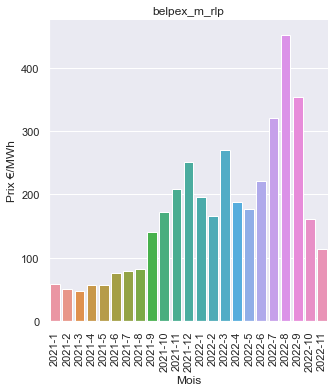

In [182]:
df = belpex_m_rlp.loc["2021":"2022"].reset_index()
df["month"] = df["index"].dt.year.astype(str) + "-" + df["index"].dt.month.astype(str)
g = sns.catplot(data=df, x="month", y="price", kind="bar")
g.set(xlabel='Mois', ylabel='Prix €/MWh')
g.set_xticklabels(rotation=90)
g.set(title="belpex_m_rlp")
None

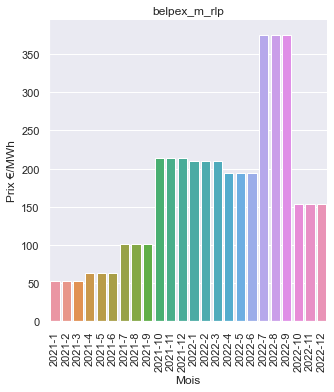

In [183]:
df = belpex_q_rlp.loc["2021":"2022"].reset_index()
df["month"] = df["index"].dt.year.astype(str) + "-" + df["index"].dt.month.astype(str)
g = sns.catplot(data=df, x="month", y="price", kind="bar")
g.set(xlabel='Mois', ylabel='Prix €/MWh')
g.set_xticklabels(rotation=90)
g.set(title="belpex_m_rlp")
None

#### En résumé, pour le Belpex, quelle différence?

En pratique il y a très peu de différence entre ces quatres indices. Les différences seront subtiles et vraiment à la marge, certainement inférieures à 5%. On peut s'amuser à faire le calcul pour le ménage "moyen", suivant la courbe RLP.

In [239]:
def f(v, start, end):
    return (rlp_elec_monthly.loc[start:end].value*v.loc[start:end].price).sum()/rlp_elec_monthly.loc[start:end].value.sum()


Markdown(tabulate.tabulate([
    ["`belpex_m`", 
     f'{f(belpex_m, "2021", "2021"):0.2f} €/MWh', 
     f'{f(belpex_m, "2022-01", "2022-11"):0.2f} €/MWh'],
    ["`belpex_q`", 
     f'{f(belpex_q, "2021", "2021"):0.2f} €/MWh', 
     f'{f(belpex_q, "2022-01", "2022-11"):0.2f} €/MWh'],
    ["`belpex_m_rlp`", 
     f'{f(belpex_m_rlp, "2021", "2021"):0.2f} €/MWh', 
     f'{f(belpex_m_rlp, "2022-01", "2022-11"):0.2f} €/MWh'],
    ["`belpex_q_rlp`", 
     f'{f(belpex_q_rlp, "2021", "2021"):0.2f} €/MWh', 
     f'{f(belpex_q_rlp, "2022-01", "2022-11"):0.2f} €/MWh']],
    headers=["Indice", "prix moyen 2021", "prix moyen 2022"],
    tablefmt="markdown"))

Indice          prix moyen 2021    prix moyen 2022
--------------  -----------------  -----------------
`belpex_m`      107.00 €/MWh       226.46 €/MWh
`belpex_q`      105.85 €/MWh       230.85 €/MWh
`belpex_m_rlp`  109.85 €/MWh       229.97 €/MWh
`belpex_q_rlp`  109.85 €/MWh       233.23 €/MWh

Notez bien que les prix de 2022 sont jusqu'au milieu du mois de Novembre, ce qui casse légèrement la propriété énoncée ci-dessus pour les contrats pondérés RLP (`q`=`m`), même si ça reste vrai pour des années complètes (on le voit pour 2021). 

On voit que la différence est très limitée, et que le meilleur indice dépend de l'année. On tentera donc de prendre un contrat non-pondéré par RLP, mais pas d'inquiétude concernant la durée d'indexation (si ce n'est pour avoir une meilleure visibilité).

### Le marché "future": `endex103`, `endex303`, et `endexXYZ` en général

Le marché "future", aussi appelé Endex, permet d'acheter de l'énergie qui sera livrée plus tard. Ce "plus tard" peut être très variable: on peut acheter de l'énergie pour le mois prochain, pour dans deux mois, pour un autre trimestre, pour dans deux ans... et ce à des durées variables: pour un mois, pour un trimestre, voire pour une année complète.

Il est donc possible de construire beaucoup d'indices différents. Dans les contrats listés plus tôt dans ce billet de blog, l'indice utilisé en général est `endex103`. Le `103` signifie qu'on va regarder le prix moyen de l'électricité pour livraison durant le trimestre pendant le mois précédent le trimestre.

Par exemple, pour le quatrième trimestre de 2022, `endex103` est le prix moyen d'acheter, au cours du mois de Septembre, de l'énergie pour livraison au dernier trimestre.

D'autres formules sont possibles. La règle générale est la suivante: pour `endexXYZ` (pour `endex103`, on a donc $X=1$, $Y=0$ et $Z=3$), le prix pour les mois $M+1$ jusque $M+Z$ sont calculés à partir du prix d'achat de l'énergie pour ces mêmes mois aux mois $M-Y$ jusque $M-Y-X+1$. Pour `endex303` le prix pour $M+1=\text{Octobre}, M+2=\text{Novembre}, M+3=\text{Décembre}$ est calculé sur la base du prix d'achat de l'énergie, pour livraison durant ces mois, pendant les mois de $M-0-0=\text{Septembre}, M-0-1=\text{Aout}, M-0-2=\text{Juillet}$. Pour `endex-12-0-12` il s'agit donc du prix moyen de livraison d'une année pendant l'année précédente (on regarde les prix en 2021 pour livraison en 2022). Pour `endex-12-12-12`, on décale: on regarde les prix de 2020 pour livraison en 2022. 

J'espère que vous êtes encore avec moi. Le plus dur est passé, je pense.

A la différence d'un indice *day-ahead*, les indices *future* ont l'avantage d'être connu *avant la consommation*. Etant donné qu'on se base sur les prix des mois précédents, le prix auquel vous consommez votre énergie est connu à l'avance.

Voici les prix récents de `endex103`:

In [241]:
import camelot

tables = camelot.read_pdf("https://www.creg.be/sites/default/files/assets/Tarifs/ElectricityQuotations-FR.pdf", flavor='stream')
df = tables[0].df.iloc[3:,[0,2]].rename(columns={0:"date", 2:"price"})
df.date = df.date.apply(lambda x: pd.to_datetime(date(year=int(x.split("/")[1]), month=int(x.split("/")[0]), day=1)))
df.price = df.price.apply(lambda x: float(x.replace(",", ".")))
endex_103 = df.set_index("date").tz_localize("CET")

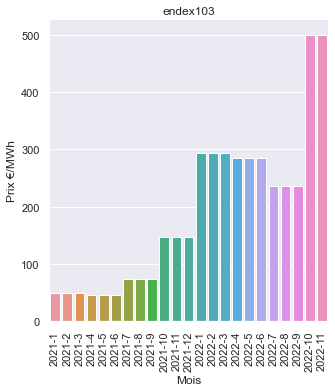

In [246]:
df = endex_103.loc["2021":"2022"].reset_index()
df["month"] = df.date.dt.year.astype(str) + "-" + df.date.dt.month.astype(str)
g = sns.catplot(data=df, x="month", y="price", kind="bar")
g.set(xlabel='Mois', ylabel='Prix €/MWh')
g.set_xticklabels(rotation=90)
g.set(title="endex103")
None

500€/MWh ce trimestre (fin 2022)!

#### Pourquoi une telle différence avec le belpex?

Contrairement à ce qu'on pourrait croire (ou pas), le marché est très mauvais pour prédire les prix de l'électricité future. On pourrait s'attendre à ce que le tarif endex de livraison au mois d'octobre acheté en septembre, soit proche du prix day-ahead du mois d'octobre. 

Il n'est est rien, et en fait, le prix endex d'aujourd'hui pour le futur proche est correlé avec le prix day-ahead d'aujourd'hui:

In [249]:
# ENDEX 101 history
url = 'https://power-scheduling.lampiris.be/C/Fr/Endex/EndexMQ.html'
header = {"User-Agent": "Mozilla/5.0"}
r = requests.get(url, headers=header)
df = pd.read_html(r.text, attrs={"class":"Table"}, parse_dates=True)[0]
df["Month"] = pd.to_datetime(df["Month"])
df = df.rename(columns={"Month":"date"}).set_index("date")
endex_101 = df[["Endex-M"]].copy().rename(columns={"Endex-M": "price"})
endex_101["price"] = endex_101["price"].str.rstrip('/MWh \x80').astype(np.float64)
endex_101.index = endex_101.index.tz_localize("CET")
endex_101 = endex_101.sort_index()

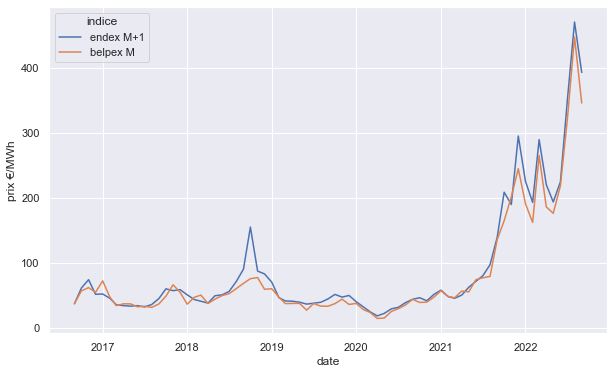

In [252]:
df = endex_101.copy()
df.index -= pd.offsets.MonthBegin(1)
df = pd.concat([df.rename(columns={"price":"endex M+1"}), 
                belpex_m.rename(columns={"price":"belpex M"})], axis=1).dropna()
df = df.melt(ignore_index=False).reset_index().rename(columns={"index":"date", "variable": "indice", "value": "prix €/MWh"})
df


sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(x="date", y="prix €/MWh", hue="indice", data=df)
None

Sur ce graphique, on voit le prix d'acheter de l'énergie "pour demain" (day-ahead, `belpex M`) ou "pour le mois prochain" (future, `endex M+1`). On voit un très, très forte corrélation entre les deux. On remarque aussi qu'en général le prix "future" est légèrement plus élévé.

La raison de l'explosion du tarif `endex103` c'est qu'au mois d'aout/septembre, on a vu une explosion des marchés day-ahead et future dûs à l'incertitude liée à la guerre en Ukraine ET à l'état des centrales nucléaires en France, massivement et exceptionnelement en panne. En cas de forte incertitude, les marchés future ont tendance à accroitre leur tarif par "sécurité". Le prix excessif de septembre s'est donc retrouvé "gardé" pour tout le trimestre fin 2022.

On peut en tirer les conclusions suivantes:

- Les tarifs "pour demain" et "pour le futur proche" sont généralement très similaires
- Donc, les tarifs basés sur endex sont un décalage des tarifs belpex
- Donc, il est intéressant d'avoir un tarif endex quand le marché monte (pour garder les prix bas passés plus longtemps)
  et d'avoir un tarif belpex quand le marché descend (pour éviter les prix passés très cher)

Voici le même graphique pour le trimestre suivant:

In [253]:
from bs4 import BeautifulSoup
header = {"User-Agent": "Mozilla/5.0"}
r = requests.get("https://www.engie.be/fr/energie/electricite-gaz/prix-conditions/parametres-indexation/parametres-indexation-electricite/", headers=header)
soup = BeautifulSoup(r.text, 'html.parser')

french_months = {
    "Janvier": 1,
    "Février": 2,
    "Mars": 3,
    "Avril": 4,
    "Mai": 5,
    "Juin": 6,
    "Juillet": 7,
    "Août": 8,
    "Septembre": 9,
    "Octobre": 10,
    "Novembre": 11,
    "Décembre": 12
}

endex_303 = []
for entry in soup.find_all(class_="table_body table_wide table_col5 text-center")[0].find_all(class_="table_row"):
    try:
        datestring = entry.find(class_="cell1").text.strip()    
    except:
        continue
    
    if "trimestre" not in datestring:
        months = [french_months[datestring.split(" ")[0]]]
        year = int(datestring.split(" ")[1])
    else:
        trim = int(datestring.split(" ")[0][0])
        months = [1+(trim-1)*3, 2+(trim-1)*3, 3+(trim-1)*3]
        year = int(datestring.split(" ")[-1])
    
    try:
        e303 = float(entry.find(class_="cell2").find("div").text.strip().replace(",","."))
        for m in months:
            endex_303.append([pd.to_datetime(date(year=year, month=m, day=1)), e303])
        
    except:
        continue

while endex_303[0][0].month % 3 != 0:
    endex_303 = [[endex_303[0][0] + pd.offsets.MonthBegin(1), endex_303[0][1]]] + endex_303

endex_303 = pd.DataFrame(endex_303, columns=["date", "price"]).set_index("date").tz_localize("CET").sort_index()

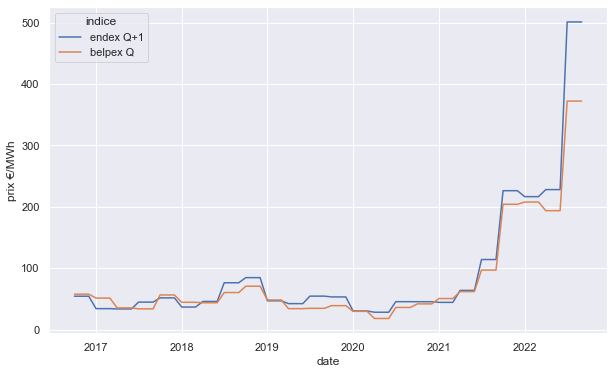

In [255]:
df = endex_303.copy()
df.index -= pd.offsets.MonthBegin(3)
df = pd.concat([df.rename(columns={"price":"endex Q+1"}), 
                belpex_q.rename(columns={"price":"belpex Q"})], axis=1).dropna()
df = df.melt(ignore_index=False).reset_index().rename(columns={"index":"date", "variable": "indice", "value": "prix €/MWh"})
df


sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(x="date", y="prix €/MWh", hue="indice", data=df)
None

### Les tarifs composites

Le seul tarif composite utilisé actuellement est le `EMarketCWE`. Il est en fait une moyenne entre `endex-12-12-12`, `endex-12-0-12` et `endex303`. Autrement dit, pour, disons, le 4ième trimestre 2022, il est la moyenne entre:

- `endex-12-12-12`: Le prix d'achat d'énergie pour tout 2022, achetée en 2020
- `endex-12-0-12`: Le prix d'achat d'énergie pour tout 2022, achetée en 2021
- `endex303`: Le prix d'achat d'énergie pour le 4ième trimestre 2022, achetée lors du 3ième trimestre 2022.

Bien que `endex303` soit extrèmement cher ce trimestre (500€/MWh), les autres sont très faibles: on ne savait pas en 2020 et en 2021 que la guerre en Ukraine allait arriver ou que le parc nucléaire français allait souffrir, et on était même en plein milieu de la crise du covid!

In [258]:
jan_22_ecwe = 118.82
jan_22_303 = 226.43

jan_21_ecwe = 44.92
jan_21_303 = 45.80

base_EMarketCWE_2022 = jan_22_ecwe-(jan_22_303/3)
base_EMarketCWE_2021 = jan_21_ecwe-(jan_21_303/3)

#base_EMarketCWE_2021, base_EMarketCWE_2021

eMarketCWE = endex_303.loc["2021-01-01":"2022-12-31"].copy()/3
eMarketCWE.loc["2021-01-01":"2021-12-31"] += base_EMarketCWE_2021
eMarketCWE.loc["2022-01-01":"2022-12-31"] += base_EMarketCWE_2022

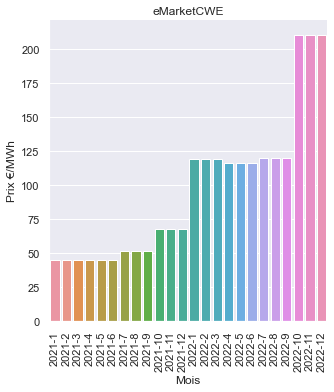

In [260]:
df = eMarketCWE.loc["2021":"2022"].reset_index()
df["month"] = df.date.dt.year.astype(str) + "-" + df.date.dt.month.astype(str)
g = sns.catplot(data=df, x="month", y="price", kind="bar")
g.set(xlabel='Mois', ylabel='Prix €/MWh')
g.set_xticklabels(rotation=90)
g.set(title="eMarketCWE")
None

Ce tarif permet donc d'avoir un indice largement en dessous des prix de marché. Alléchant. Malheureusement, le fournisseur qui utilise cet indice, Luminus, n'est pas dupe: pour compenser le prix extrèmement bas de l'indice, il ajoute un bais (le $y$ dans le tableau des contrats) très élevé pour compenser. Ce qui fait qu'aucun contrat basé sur `eMarketCWE` n'est intéressant pour l'instant.

## Un récapitulatif des indices

- Le Belpex, pour l'instant, est le seul bon choix, vu les prix exorbitant du endex103/endex303 pour ce trimestre.
- En général, les tarifs endex ("future") ont tendance à être un peu plus cher que les tarifs belpex ("day-ahead")

## A la recherche du meilleur contrat

Maintenant que l'on a une bonne idée des différents indices, on peut comparer les différents contrats. A cette fin, nous allons poser quelques hypothèses.

La première, c'est qu'on va tenter de tout mettre en rapport avec `belpex_m` et `belpex_q`. Pour chaque contrat sur un indice différent, on va les "convertir" vers ces indices. Pour cela on va calculer les différences de prix moyennes entre chaque indice sur 2021 et 2022.

In [274]:
# Quelques hypothèses:
# belpex_m = belpex_q = 1
# on regarde endex101/endex103 décalé de 1 mois et endex303 décale de 3 mois

def mean_endex101():
    df = endex_101.copy()
    df.index -= pd.offsets.MonthBegin(1)
    df = pd.concat([df.rename(columns={"price":"endex M+1"}), 
                    belpex_m.rename(columns={"price":"belpex M"})], axis=1).dropna()
    return (((df["endex M+1"] / df["belpex M"])-1)*100.0).mean()

def mean_endex103():
    df = endex_103.copy()
    df.index -= pd.offsets.MonthBegin(1)
    df = pd.concat([df.rename(columns={"price":"endex M+1"}), 
                    belpex_m.rename(columns={"price":"belpex M"})], axis=1).dropna()
    return (((df["endex M+1"] / df["belpex M"])-1)*100.0).mean()

def mean_endex303():
    df = endex_303.copy()
    df.index -= pd.offsets.MonthBegin(3)
    df = pd.concat([df.rename(columns={"price":"endex M+1"}), 
                    belpex_m.rename(columns={"price":"belpex M"})], axis=1).dropna()
    return (((df["endex M+1"] / df["belpex M"])-1)*100.0).mean()

def mean_belpex_m():
    return 0.0

def mean_belpex_q():
    return 0.0

def mean_belpex_m_rlp():
    return ((belpex_m_rlp/belpex_m)["price"].mean() - 1) * 100.0

def mean_belpex_q_rlp():
    return ((belpex_q_rlp/belpex_q)["price"].mean() - 1) * 100.0

def mean_eMarketCWE():
    return ((eMarketCWE/belpex_q)["price"].mean() - 1)*100.0

indexes_coefs = {
    #"endex101": mean_endex101(),
    "endex103": mean_endex103(),
    #"endex303": mean_endex303(),
    "belpex_m": mean_belpex_m(),
    "belpex_q": mean_belpex_q(),
    "belpex_m_rlp": mean_belpex_m_rlp(),
    "belpex_q_rlp": mean_belpex_q_rlp(),
    "EMarketCWE": mean_eMarketCWE()
}

Markdown(tabulate.tabulate([[f"`{x}`", f"{y:0.2f}"] for x, y in indexes_coefs.items()],
    headers=["Indice", "Pourcentage de différence avec belpex, moyenne"],
    tablefmt="markdown"))

Indice            Pourcentage de différence avec belpex, moyenne
--------------  ------------------------------------------------
`endex103`                                                 22.18
`belpex_m`                                                  0
`belpex_q`                                                  0
`belpex_m_rlp`                                              1.97
`belpex_q_rlp`                                              2.02
`EMarketCWE`                                              -33.14

On peut ensuite reprendre notre tableau des contrats au dessus, et convertir les multiplicateurs, en faisant comme si tout était du `belpex_m`:

In [283]:
simplified_contracts = [
    x._replace(index="belpex_m",
              mono=(x.mono[0]*(100.+indexes_coefs[x.index])/100, x.mono[1]),
              day=(x.day[0]*(100.+indexes_coefs[x.index])/100, x.day[1]),
              night=(x.night[0]*(100.+indexes_coefs[x.index])/100, x.night[1]),
              excl_night=(x.excl_night[0]*(100.+indexes_coefs[x.index])/100, x.excl_night[1]))
    for x in contracts
]

table_out = """
<table class='contracts_table'>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th colspan="2" class="mono">Monohoraire</th>
        <th colspan="2" class="day">Bihoraire (moyenne 50/50)</th>
    </tr>
    <tr>
        <th class="mono">x</th>
        <th class="mono">y</th>
        <th class="day">x</th>
        <th class="day">y</th>
    </tr>
"""

for contract in simplified_contracts:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td class="mono val">{contract.mono[0]:0.4f}</td>
        <td class="mono val">{contract.mono[1]:0.3f}</td>
        <td class="day val">{(contract.day[0]+contract.night[0])/2:0.4f}</td>
        <td class="day val">{(contract.day[1]+contract.night[1])/2:0.3f}</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

Une seconde hypothèse que l'on va poser, c'est que l'on néglige les coûts fixes liés aux contrats. Ils devraient être faible vis-a-vis des économies à faire, de toute manière. On peut ensuite entreprendre de supprimer tout les contrats "dominés", c'est à dire tel qu'un autre contrat a en même temps un $x$ et un $y$ plus petit. Un tel contrat sera toujours plus cher.

In [299]:
non_dominated_mono = sorted([
    x
    for x in simplified_contracts
    if not any(y.mono[0] <= x.mono[0] and y.mono[1] <= x.mono[1] for y in simplified_contracts if x != y)
], key=lambda x: (x.mono[1], x.mono[0]))

table_out = """
<table class='contracts_table'>
    <tr><th colspan="5">Contrats non-dominés, monohoraire</th></tr>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th colspan="2" class="mono">Monohoraire</th>
    </tr>
    <tr>
        <th class="mono">x</th>
        <th class="mono">y</th>
    </tr>
"""

for contract in non_dominated_mono:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td class="mono val">{contract.mono[0]:0.4f}</td>
        <td class="mono val">{contract.mono[1]:0.3f}</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

In [323]:
non_dominated_bi = sorted([
    x
    for x in simplified_contracts
    if not any((y.day[0] + y.night[0]) <= (x.day[0] + x.night[0]) and (y.day[1] + y.night[1]) <= (x.day[1] + x.night[1]) for y in simplified_contracts if x != y)
], key=lambda x: (x.day[1] + x.night[1], x.day[0] + x.night[1]))

table_out = """
<table class='contracts_table'>
    <tr><th colspan="5">Contrats non-dominés, bihoraire</th></tr>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th colspan="2" class="day">Bihoraire (moyenne 50/50)</th>
    </tr>
    <tr>
        <th class="day">x</th>
        <th class="day">y</th>
    </tr>
"""

for contract in non_dominated_bi:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td class="day val">{(contract.day[0]+contract.night[0])/2:0.4f}</td>
        <td class="day val">{(contract.day[1]+contract.night[1])/2:0.3f}</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

Tout les contrats éléminés, sous nos hypothèses, sont strictement plus cher que ceux qui restent (et donc nuls™). Parmi ceux qui restent, lesquels choisir? Eh bien cela dépend du prix de marché. Les contrats les plus en haut de chaque tableau ont un très petit $y$ mais un $x$ large. Avec de faible prix de marché, le biais $y$ des contrats devient prépondérant dans la valeur de l'énergie, et ces contrats seront favorisés.

Inversement, si les prix de marché sont élévés, le biais $y$ va devenir insignifiant par rapport à la marge proportionnelle prise via $x$, et les contrats du fond des tableaux seront meilleurs.

On peut donc mesurer les intervalles entre lesquels chaque contrat est le meilleur. Par la magie des maths (et plus spécifiquement des équations linéaires) on va encore trouver d'autres contrats dominés. 

:::{.callout-note}
Par exemple, en monohoraire, le contrat d'Eneco et Luminus-Essential se croisent à 693€/MWh. Mais le contrat Engie-Flow et celui d'Eneco se croisent à 982€/MWh: autrement dit, Engie-Flow est moins cher jusqu'à 982€. On en conclus que le contrat d'Eneco est toujours dominé.
:::

In [318]:
#x1 * a + y1 == x2 * a + y2
#(x1 - x2) * a == y2 - y1
#a == (y2 - y1)/(x1 - x2)

def solve(entries, f=lambda x: x.mono):
    out = []
    out.append((entries[0], 0.0))
    cur = 1
    while cur < len(entries):
        x1, y1 = f(out[-1][0])
        x2, y2 = f(entries[cur])
        next_val = (y2 - y1)/(x1 - x2)
        
        if next_val < out[-1][1]:
            del out[-1]
            continue
            
        out.append((entries[cur], next_val))
        cur += 1
    return out

non_dominated_mono_2 = solve(non_dominated_mono, f=lambda x: x.mono)
non_dominated_bi_2 = solve(non_dominated_bi, f=lambda x: ((x.day[0] + x.night[0])/2, (x.day[1] + x.night[1])/2))

In [326]:
table_out = """
<table class='contracts_table'>
    <tr><th colspan="6">Contrats non-dominés, monohoraire</th></tr>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th colspan="2" class="mono">Monohoraire</th>
        <th rowspan="2" class="mono">Meilleur à partir de</th>
    </tr>
    <tr>
        <th class="mono">x</th>
        <th class="mono">y</th>
    </tr>
"""

for contract, startv in non_dominated_mono_2:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td class="mono val">{contract.mono[0]:0.4f}</td>
        <td class="mono val">{contract.mono[1]:0.3f}</td>
        <td class="mono val">{startv:0.1f} €/MWh</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

In [325]:
table_out = """
<table class='contracts_table'>
    <tr><th colspan="6">Contrats non-dominés, bihoraire</th></tr>
    <tr>
        <th rowspan="2">Fournisseur</th>
        <th rowspan="2">Contrat</th>
        <th rowspan="2">Coût fixe (€/an)</th>
        <th colspan="2" class="day">Bihoraire</th>
        <th rowspan="2" class="day">Meilleur à partir de</th>
    </tr>
    <tr>
        <th class="day">x</th>
        <th class="day">y</th>
    </tr>
"""

for contract, startv in non_dominated_bi_2:
    table_out += f"""
    <tr>
        <td>{contract.company}</td>
        <td>{contract.name}</td>
        <td>{contract.annual}</td>
        <td class="day val">{(contract.day[0]+contract.night[0])/2:0.4f}</td>
        <td class="day val">{(contract.day[1]+contract.night[1])/2:0.3f}</td>
        <td class="day val">{startv:0.1f} €/MWh</td>
    </tr>
    """
table_out += """</table>"""

HTML(table_out)

Etant donné les prix de marchés oscillant actuellement entre 100 et 200 €/MWh, la différence entre le contrat DATS24-Variable et Engie-Flow est faible pour le mono-horaire. Pour le bihoraire, Engie-Flow sort grand gagnant.

En règle générale, je ne peux que conseiller Engie-Flow, ou son grand frère Engie-Direct. Engie-Direct est un peu plus cher au niveau  de l'énergie, mais moins au niveau des coûts fixes. Pour le consomatteur moyen, cela devrait revenir approximativement au même. Par ailleurs, Engie-Flow n'est pas disponbile sur le site internet d'Engie (uniquement via le chat ou par téléphone, apparement), alors que Direct oui.

:::{.callout-caution}
ATTENTION: on parle ici du meilleur contrat d'électricité! Ne prenez pas le contrat de gaz nommé Flow chez Engie, qui est particulièrement mauvais par rapport à Direct, par exemple.
:::

:::{.callout-note}
Rien ne vous empèche d'avoir un fournisseur différent pour le gaz et l'élec, ni d'avoir deux types de contrats chez un même fournisseur (par exemple Engie-flow pour l'élec et Engie-direct pour le gaz).
:::

Par ailleurs, Engie propose un contrat basé sur `endex103`. Bien qu'il s'agisse d'un des plus mauvais contrat du marché ce semestre, il pourrait peut-être devenir intéressant dans le futur, et Engie ne facture pas de nouveau les prix fixes quand on change de type de contrat en *restant* client. Pratique!

## Pro-tips pour changer de contrat

- La majorité des contrats sont accessibles directement en ligne. Ca prends quelques instants!
- Si ça n'est pas le cas, n'hésitez pas à téléphoner. Il faudra s'armer de patience...
- Vous avez le droit de prendre des contrats différents pour le gaz et l'élec. D'ailleurs, vous devriez ;-)
- Vous pouvez techniquement changer de contrat/fournisseur chaque mois. N'hésitez donc pas à faire fonctionner la concurrence...
- ... mais attention aux frais fixes ...
- Certains fournisseurs facturent les frais fixes en entier lors de la création du contrat, d'autre facturent au pro-rata du nombre de jour passé dans le contrat, avec un minimum de 6 mois. N'oubliez pas de prendre ça en compte dans votre calcul.
- Les indices des nouveaux contrats changent tout les mois. Trouver le contrat parfait nécessite de regarder chaque mois ce qu'il se passe...
- Un changement de fournisseur est un bon moyen de forcer le décompte.
- N'hésitez pas à envoyer un mail tout les 3 mois à votre fournisseur avec votre dernier index de compteur, pour qu'il puisse calculer si votre acompte est toujours correct.

## Questions ouvertes

- Que se passe t'il si on casse un contrat `belpex_q` en milieu de trimestre? Comment est déterminé le prix du dernier trimestre?

## TODO

- Discussions sur les acomptes.
- Mettre en ligne les outils interactifs
- Et si j'étais ministre?
- Lien sociaux (twitter/mail)